In [17]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "static" / "data"

In [18]:
# enable WFS support
import fiona
fiona.drvsupport.supported_drivers['WFS'] = 'r'

In [19]:
import geopandas
import ssl

In [20]:
# Method below isn't working so I downloaded the file and will read it in from the dir
DATA_DIR2 = NOTEBOOK_PATH / "static" / "data" / "Vaestotietoruudukko_2020_shp"
addresses = geopandas.read_file(DATA_DIRECTORY / "addresses.gpkg")
population_grid = geopandas.read_file(DATA_DIR2 / "Vaestotietoruudukko_2020.shp")
population_grid.crs = "EPSG:3879"

In [21]:

# Need to be able to read the file from the server - getting an SSL issue
# ssl._create_default_https_context = ssl._create_unverified_context

# addresses = geopandas.read_file(DATA_DIRECTORY / "addresses.gpkg")

# population_grid = geopandas.read_file(
#     (
#         "https://kartta.hsy.fi/geoserver/wfs"
#         "?service=wfs"
#         "&version=2.0.0"
#         "&request=GetFeature"
#         "&typeName=asuminen_ja_maankaytto:Vaestotietoruudukko_2020"
#         "&srsName=EPSG:3879"
#     ),
# )
# population_grid.crs = "EPSG:3879"  # for WFS data, the CRS needs to be specified manually

In [22]:
population_grid.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,703,5,51.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
1,710,8,44.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
2,711,5,90.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
3,715,13,34.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."
4,848,5,53.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472749.993 6690249.003, 25472749.9..."


In [25]:
population_grid = population_grid[["ASUKKAITA", "geometry"]]
population_grid = population_grid.rename(columns={"ASUKKAITA": "population"})
population_grid.head()

,population,geometry
0,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
1,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
2,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
3,13,"POLYGON ((25472499.995 6682998.998, 25472499.9..."
4,5,"POLYGON ((25472749.993 6690249.003, 25472749.9..."



If you need to use very large numbers, such as, in the above example, the 1 million to convert m² to km², you can use underscore characters (_) as thousands separators. The Python interpreter will treat a sequence of numbers interleaved with underscores as a regular numeric value. You can use the same syntax to group numbers by a different logic, for instance, to group hexadecimal or binary values into groups of four.

In case an expression, such as, e.g., a mathematical formula, spreads across multiple lines, it is considered good coding style to place an operator at the beginning of a new line, rather than let it trail in the previous line. This is considered more readable, as explained in the PEP-8 styling guidelines

In [26]:
population_grid["population_density"] = (
    population_grid["population"]
    / (population_grid.area / 1_000_000)
)
population_grid.head()

,population,geometry,population_density
0,5,"POLYGON ((25472499.995 6685998.998, 25472499.9...",80.001048
1,8,"POLYGON ((25472499.995 6684249.004, 25472499.9...",128.001677
2,5,"POLYGON ((25472499.995 6683999.005, 25472499.9...",80.001048
3,13,"POLYGON ((25472499.995 6682998.998, 25472499.9...",208.002724
4,5,"POLYGON ((25472749.993 6690249.003, 25472749.9...",79.998352


<AxesSubplot: >

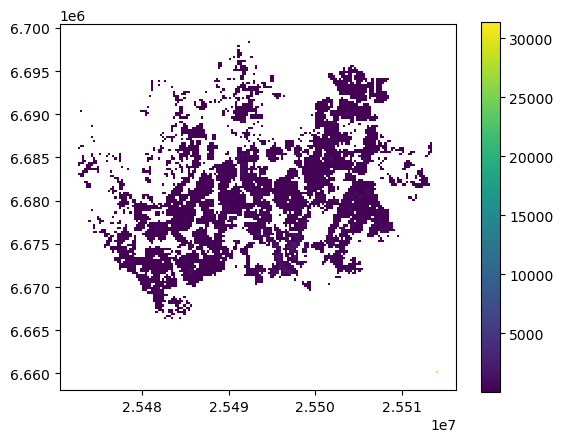

In [32]:
population_grid.plot(column = 'population', legend = True)

In [33]:
assert addresses.crs == population_grid.crs, "CRS are not identical"

AssertionError: CRS are not identical

In [34]:
population_grid = population_grid.to_crs(addresses.crs)

In [35]:
addresses_with_population_data = addresses.sjoin(
    population_grid,
    how="left",
    predicate="within"
)
addresses_with_population_data.head()

,address,geometry,index_right,population,population_density
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",POINT (24.91556 60.16320),3247.0,492.0,7872.103107
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",POINT (24.93166 60.16905),3362.0,182.0,2912.038141
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",POINT (24.94179 60.16989),3485.0,45.0,720.009431
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",POINT (24.97840 60.18934),3824.0,686.0,10976.143764
4,"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",POINT (24.92169 60.15667),3293.0,1410.0,22559.535399


Text(0.5, 1.0, 'Population density around address points')

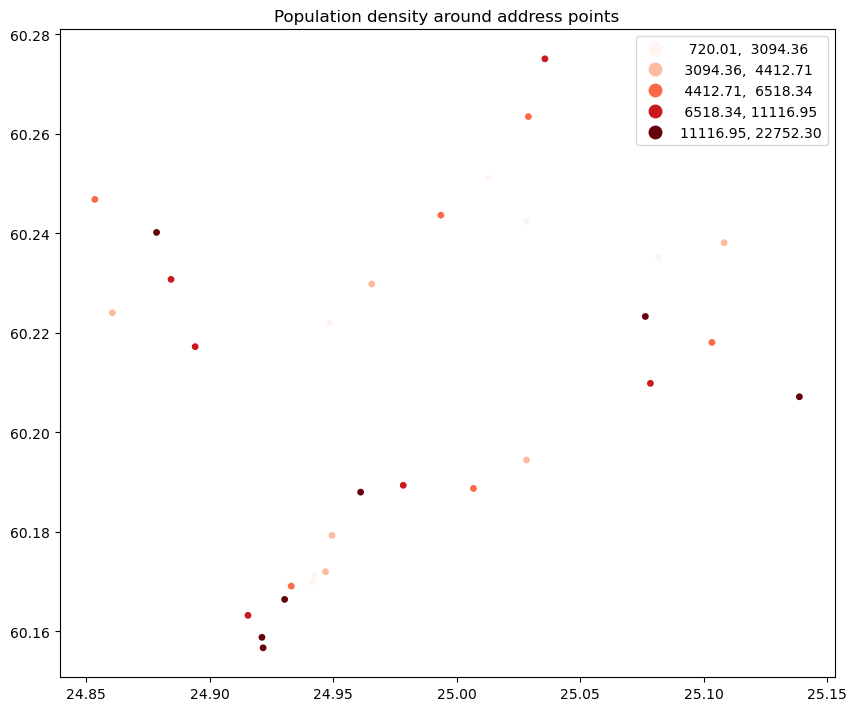

In [36]:
ax = addresses_with_population_data.plot(
    figsize=(10, 10),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    markersize=15,
    legend=True
)
ax.set_title("Population density around address points")

Text(0.5, 1.0, 'Population density in the Helsinki metropolitan area')

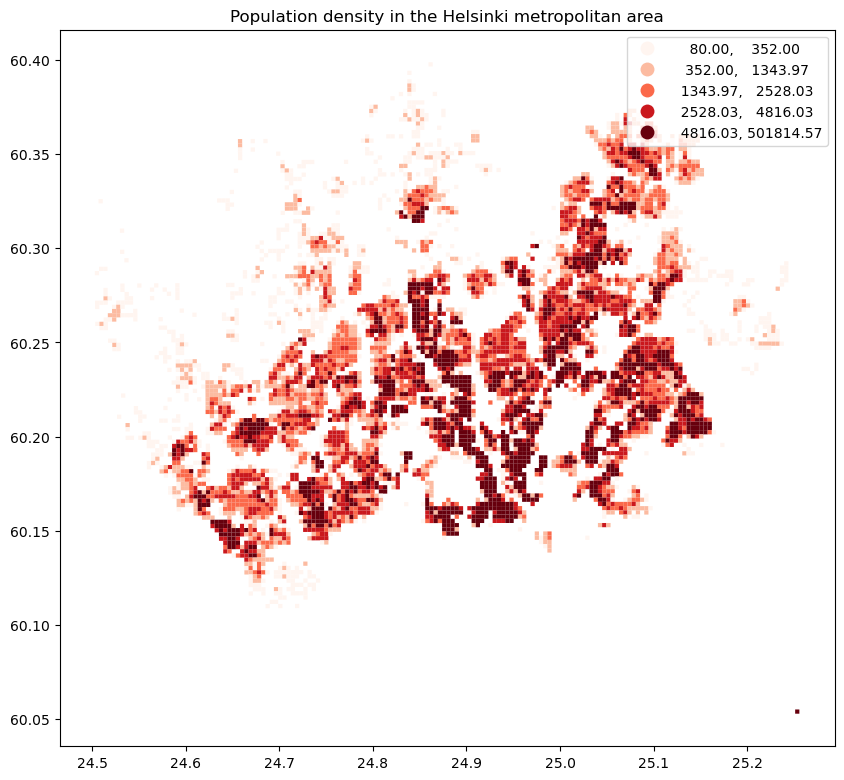

In [37]:
ax = population_grid.plot(
    figsize=(10, 10),
    column="population_density",
    cmap="Reds",
    scheme="quantiles",
    legend=True
)
ax.set_title("Population density in the Helsinki metropolitan area")

In [38]:
addresses_with_population_data.to_file(
    DATA_DIRECTORY / "addresses.gpkg",
    layer="addresses_with_population_data"
)